# MSP projekt 2 - Ondřej Lukášek (xlukas15)

Začnu tím, že si naimportuji potřebné knihovny, se kterými budu v projektu pracovat.

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as stats
import scipy.special as special
import statsmodels.api as smf

## Úkol 1 - Věrohodnost

Nejprve si načtu list (sheet), který obsahuje data, se kterými budu pracovat.

Předpřipravím si parametry tak, abych je mohl rovnou použít dál.

In [18]:
file_path = 'Data_2024.xlsx'
sheet_name = 'Data_věrohodnost'

data = pd.read_excel(file_path, sheet_name=sheet_name)
times = data['doba práce v oboru [roky]'].dropna().to_numpy()
censored = data['censored'].to_numpy()

initial_params = (1.5, 5.0)

### Bod 1

In [19]:
def weibull_log_likelihood(params, times, censored):
    k, lam = params
    
    # logaritmizace pro necenzurovana data
    log_f = np.log(k) - k * np.log(lam) + (k - 1) * np.log(times) - (times / lam)**k
    # logaritmizace pro cenzurovana data
    log_sf = - (times / lam)**k
    
    # spojeni logaritmu pro necenzurovana a cenzurovana data
    likelihood = (1 - censored) * log_f + censored * log_sf

    return likelihood.sum()


# MOZNA SMAZAT???
def weibull_log_likelihood_derivatives(params, times, censored):
    k, lam = params

    # predvypocitani konstant, co se budou v derivacich opakovat
    t_lam_k = (times / lam)**k
    log_t_lam = np.log(times / lam)
    
    # parcialni derivace logaritmu podle parametru k
    dL_dk = np.sum((1 - censored) * (1 / k + log_t_lam - t_lam_k * log_t_lam) + censored * (-t_lam_k * log_t_lam))
    # parcialni derivace logaritmu podle parametru lambda
    dL_dlam = np.sum((1 - censored) * (-k / lam + k * t_lam_k / lam) + censored * (k * t_lam_k / lam))
    
    return np.array([dL_dk, dL_dlam])


log_likelihood = weibull_log_likelihood(initial_params, times, censored)
derivatives = weibull_log_likelihood_derivatives(initial_params, times, censored)

print(f'Log-likelihood: {log_likelihood}')
print(f'Derivatives: {derivatives}')

Log-likelihood: -740.8976732574417
Derivatives: [64.24195393 77.00791218]


### Bod 2

In [20]:
def neg_weibull_log_likelihood(params, times, censored):
    return -weibull_log_likelihood(params, times, censored)

result = opt.minimize(
    fun=neg_weibull_log_likelihood,
    x0=initial_params,
    args=(times, censored),
    method='L-BFGS-B',
    bounds=[(0.1, None), (0.1, None)]
)

optimal_shape, optimal_scale = result.x

print('Maximal likelihood estimation:')
print(f'Shape (k): {optimal_shape}')
print(f'Scale (lambda): {optimal_scale}')

Maximal likelihood estimation:
Shape (k): 6.172808847674017
Scale (lambda): 7.4294603426242265


### Bod 3

Pomocí věrohodnostního poměru otestujte hypotézu, že exponenciální rozdělení je postačujícím modelem zapsaných dat (Parametr tvaru = 1).

By default je distribuční funkce (pro $ x \geq 0 $) exponenciálního rozdělení:

$ f(x; \lambda) = \lambda e^{-\lambda x} $

Logaritmus potom bude:

$ \ell(x; \lambda) = \ln \lambda - \lambda x $

Log-likelihood potom je:

$ \ell(\lambda) = \sum_{i=1}^n \left[ \ln \lambda - \lambda x_i \right]  $

In [21]:
def exponential_log_likelihood(lam, times, censored):
    log_f = np.log(lam) - lam * times
    log_sf = -lam * times

    likelihood = (1 - censored) * log_f + censored * log_sf
    return np.sum(likelihood)


result_exp = opt.minimize(
    fun=lambda lam: -exponential_log_likelihood(lam[0], times, censored),
    x0=[1.0],
    bounds=[(0.1, None)],
    method='L-BFGS-B'
)

lambda_exp = result_exp.x[0]
log_likelihood_exp = -result_exp.fun

k_weibull, lambda_weibull = result.x
result_weibull = -result.fun

# VYPOCET VEROHODNOSTNIHO POMERU
LR = 2 * (result_weibull - log_likelihood_exp)

alpha = 0.05
critical_value = stats.chi2.ppf(1 - alpha, df=1)

print(f'Likelihood ratio: {LR}')
print(f'Critical value (alpha = {alpha}): {critical_value}')

if LR > critical_value:
    print('Zamítáme nulovou hypotézu. Exponenciální rozdělení není postačující.')
else:
    print('Nulovou hypotézu nezamítáme. Exponenciální rozdělení je postačující.')

Likelihood ratio: 592.3898153427439
Critical value (alpha = 0.05): 3.841458820694124
Zamítáme nulovou hypotézu. Exponenciální rozdělení není postačující.


### Bod 4

Podle výsledku z předchozího bodu použijte výsledné rozdělení pravděpodobnosti (s maximálně věrohodnými odhady jako parametry) a nalezněte bodové odhady pro střední dobu zaměstnání v oboru a 10% percentil zaměstnání v oboru (za jakou dobu odejde do jiného oboru 10% absolventů).

Jelikož v předchozím bodu na základě testu vyšlo, že exponenciální rozdělení není postačující, budu dále pokračovat s Weibullovým rozdělením.

U Weibullova rozdělení se střední hodnota vypočítá následovně (z Wikipedie):

$ Mean = \lambda \Gamma (1 + \frac{1}{k}) $

A kvantily se počítají pomocí vzorce:

$ Q(p) = \lambda (- \ln (1 - p))^{\frac{1}{k}} \implies Q(0.1) = \lambda (- \ln (0.9))^{\frac{1}{k}} $

In [22]:
def weibull_mean(k, lam):
    return lam * special.gamma(1 + 1 / k)


def weibull_quantile(p, k, lam):
    return lam * (- np.log(1 - p))**(1 / k)


mean = weibull_mean(k_weibull, lambda_weibull)
quantile = weibull_quantile(0.1, k_weibull, lambda_weibull)

print('=== Weibull distribution ===')
print(f'Shape (k): {k_weibull}')
print(f'Scale (lambda): {lambda_weibull}\n')

print('=== Mean, Quantile ===')
print(f'Mean: {mean}')
print(f'10% quantile: {quantile}')

=== Weibull distribution ===
Shape (k): 6.172808847674017
Scale (lambda): 7.4294603426242265

=== Mean, Quantile ===
Mean: 6.903242509050911
10% quantile: 5.159769490910647


### Bod 5 (dobrovolný)

Zkuste nějak slovně charakterizovat/popsat fungování doby zaměstnání v oboru jako náhodné veličiny, dle vašich výsledků a parametrů.

**TODO**

## Úkol 2 - Regrese

Opět začnu tím, že si nejprve načtu data z Excelu. Pro jistotu si přetypuji hodnoty, abych se vyhnul problémům do budoucna (kdy náhodou něco nefungovalo). 

In [54]:
file_path = 'Data_2024.xlsx'
sheet_name = 'Data_regrese'

df = pd.read_excel(file_path, sheet_name=sheet_name)

df['OSType'] = df['OSType'].astype('category')

columns_to_numeric = ['ActiveUsers', 'InteractingPct', 'ScrollingPct', 'Ping [ms]']
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

df

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping [ms]
0,iOS,4113,0.8283,0.1717,47
1,iOS,7549,0.3461,0.6539,46
2,Windows,8855,0.2178,0.7822,55
3,Android,8870,0.0794,0.9206,56
4,MacOS,9559,0.7282,0.2718,76
...,...,...,...,...,...
497,iOS,5315,0.1974,0.8026,28
498,MacOS,1392,0.2373,0.7627,24
499,iOS,6014,0.8112,0.1888,54
500,Android,5118,0.2345,0.7655,39


### Bod 1

Pomocí zpětné eliminace určete vhodný regresní model. Za výchozí "plný" model považujte plný kvadratický model (všechny interakce druhého řádu a všechny druhé mocniny, které dávají smysl).

- Zapište rovnici Vašeho finálního modelu.
- Diskutujte splnění přepokladů lineární regrese a základní regresní diagnostiky.
- Pokud (až během regresního modelování) identifikujete některé "nejodlehlejší" hodnoty, po alespoň krátkém zdůvodnění, vyřadit.

Začnu tím, že si data vizualizuji pro lepší představu toho, s čím budu vlastně pracovat.

Zřejmě budu pracovat se závislostí odezvy na počtu aktivní uživatelů na mé "socce".

Na grafu je možné si pouhým okem všimnout rostoucí tendence - tedy čím víc je uživatelů, tím větší je ping.


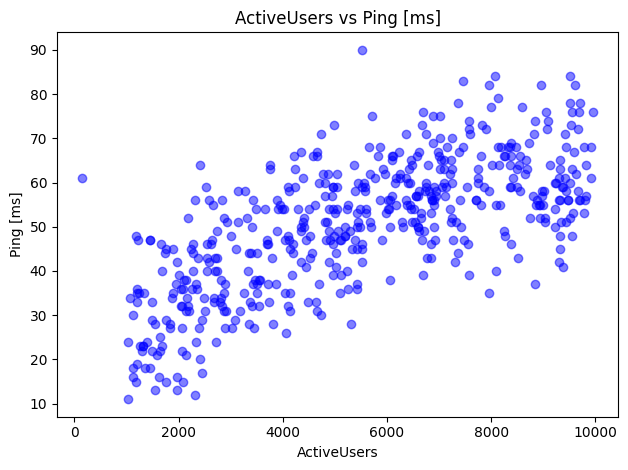

In [44]:
# ActiveUsers vs Ping [ms]
plt.scatter(df['ActiveUsers'], df['Ping [ms]'], alpha=0.5, color='blue')
plt.title('ActiveUsers vs Ping [ms]')
plt.xlabel('ActiveUsers')
plt.ylabel('Ping [ms]')


plt.tight_layout()
plt.show()